In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
import xlrd

In [3]:
# Read files
df_sd = pd.read_csv("../../../02_Data//02_SociaDemographics/us_final.csv",index_col=0)
df_sd = df_sd.reset_index()
print(df_sd.head(10))

df_case = pd.read_csv("../../../02_Data//01_COVID/covid_us_county.csv")
df_case.dropna(inplace=True)
print(df_case.head(10))

df_policy = pd.read_excel(r"../../../02_Data\03_Policy\COVID_StatePolicy_final.xlsx")

   index  fips           county    state state_code  median_age_2017  \
0      1  1001   Autauga County  Alabama         AL             37.8   
1      2  1003   Baldwin County  Alabama         AL             42.8   
2      3  1005   Barbour County  Alabama         AL             39.9   
3      4  1007      Bibb County  Alabama         AL             39.9   
4      5  1009    Blount County  Alabama         AL             40.8   
5      6  1011   Bullock County  Alabama         AL             39.6   
6      7  1013    Butler County  Alabama         AL             40.7   
7      8  1015   Calhoun County  Alabama         AL             39.7   
8      9  1017  Chambers County  Alabama         AL             43.0   
9     10  1019  Cherokee County  Alabama         AL             45.9   

   population_2017  female_percentage_2017        lat       long  ...  \
0            55200               51.315217  32.534923 -86.642730  ...   
1           208107               51.376936  30.727479 -87.722

In [4]:
df_merge=df_case.merge(df_policy, on=['state_code','state'],how='left')

In [ ]:
# get daily data from cumulative sum
df_merge['new_cases']=df_merge['cases'].groupby(df_merge['fips']).diff().fillna(0)
df_merge['new_deaths']=df_merge['deaths'].groupby(df_merge['fips']).diff().fillna(0)

# impute 0 for dates with negative case inceases
df_merge['new_cases']=df_merge['new_cases'].clip(lower=0)
df_merge['new_deaths']=df_merge['new_deaths'].clip(lower=0)

df_merge['cases_7day_ave'] = df_merge.groupby('fips', as_index=False)['new_cases'].rolling(window=7,center=True).mean().fillna(0).reset_index(
    0, drop=True)
df_merge['policy_home']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['stay_at_home'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['end_stay_at_home'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_school']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_school'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_business']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_nonessential_business'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['reopen_business'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_restaurant']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_restaurant'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['reopen_restaurant'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_facemask']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['facemask'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_gym']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_gym'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['reopen_gym'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_theater']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_theater'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['reopen_theater'].astype('datetime64[ns]')), 1, 0)

df_merge['policy_bar']=np.where((df_merge['date'].astype('datetime64[ns]')>=df_merge['close_bar'].astype('datetime64[ns]')) 
                                 & (df_merge['date'].astype('datetime64[ns]')<=df_merge['reopen_bar'].astype('datetime64[ns]')), 1, 0)


In [ ]:
df_merge = df_merge[['fips','date','policy_home','policy_school','policy_business','policy_restaurant','policy_facemask','policy_gym','policy_theater','policy_bar']]
df_merge.head(5)

In [ ]:
df_merge['fips'] = df_merge.fips.astype(int)

# Section 1: Basic sociodemographics

In [5]:
print(df_sd.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3220 entries, 0 to 3219
Data columns (total 57 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   index                   3220 non-null   int64  
 1   fips                    3220 non-null   int64  
 2   county                  3220 non-null   object 
 3   state                   3220 non-null   object 
 4   state_code              3141 non-null   object 
 5   median_age_2017         3220 non-null   float64
 6   population_2017         3220 non-null   int64  
 7   female_percentage_2017  3220 non-null   float64
 8   lat                     3220 non-null   float64
 9   long                    3220 non-null   float64
 10  Race_Hispanic           3220 non-null   float64
 11  Race_White              3220 non-null   float64
 12  Race_Black              3220 non-null   float64
 13  Race_Native             3220 non-null   float64
 14  Race_Asian              3220 non-null   

In [6]:
df_sd.loc[549,'ChildPoverty'] = df_sd[df_sd["state"]=="Hawaii"]["ChildPoverty"].median()

In [7]:
df_missing_crime = df_sd[df_sd["crime_rate_per_100000"].isnull()]
df_missing_crime_num = df_missing_crime.groupby("state")["state"].count()

crime_columns = ["crime_rate_per_100000","IDNO","Crime_CPOPARST","Crime_CPOPCRIM","Crime_AG_OFF","Crime_COVIND","Crime_MODINDX","Crime_MURDER","Crime_RAPE","Crime_ROBBERY","Crime_AGASSLT","Crime_BURGLRY","Crime_LARCENY","Crime_MVTHEFT","Crime_ARSON"]
state_list = ["Alaska","New Mexico","South Dakota"]
for state in state_list:
    index_list = df_missing_crime[df_missing_crime['state']==state]["index"].tolist()
    for crime in crime_columns:
        for index in index_list:
            df_sd.loc[index-1,crime] = df_sd[df_sd['state']==state][crime].median()

## 1, What are missing values?
state_code: The missing values are from Puerto Rico

ChildPoverty: The missing value is from fips=15005 (Hawaii). I filled the median value in Hawaii county to it

Crime variables: Alaska(7), New Mexico(1), South Dakota(1), Puerto Rico(78). I filled the missing values in Alaska, New Mexico and South Dakota with median value respectively

## 2, Patterns of features
### 2.1 Median_age
### 2.2 Population
### 2.3 Female Percentage
### 2.4 Race
### 2.5 Income


In [ ]:
plt.figure(figsize=(12,8))
plt.hist(df_sd['median_age_2017'].tolist(),bins=25)
plt.xlabel("Age", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Median_age_distribution",fontsize=20)
sns.despine(offset=10)
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(np.log10(df_sd['population_2017'].tolist()),bins=25)
plt.xlabel("log(Population Size)", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Population distribution",fontsize=20)
sns.despine(offset=10)
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(df_sd['female_percentage_2017'].tolist(),bins=25)
plt.xlabel("Female percentage", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Female percentage distribution",fontsize=20)
sns.despine(offset=10)
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
# plt.hist(df_sd['Race_White'].tolist(),bins=50,alpha=0.3,color="blue")
sns.kdeplot(df_sd['Race_White'].tolist(),shade=True,label="White")
sns.kdeplot(df_sd['Race_Black'].tolist(),shade=True,label="Black")
sns.kdeplot(df_sd['Race_Hispanic'].tolist(),shade=True,label="Hispanic")
# sns.kdeplot(df_sd['Race_Native'].tolist(),shade=True)
# sns.kdeplot(df_sd['Race_Asian'].tolist(),shade=True)
# plt.hist(df_sd['Race_Black'].tolist(),bins=50,alpha=0.3,color="red")
# plt.hist(df_sd['Race_Hispanic'].tolist(),bins=50,alpha=0.3,color="green")
plt.xlim(0,100)
plt.xlabel("Race percentage in each county", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Race percentage distribution",fontsize=20)
sns.despine(offset=10)
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
plt.hist(df_sd['Income'].tolist(),bins=25)
plt.xlabel("Income", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Income distribution",fontsize=20)
sns.despine(offset=10)
plt.show()

# Section 2 correlations

1, The higher the median age, the higher ratio of white people in a county, the less hispanic people in a county

2, The higher the median age, the higher ratio of self-employed

3, The larger the population size, the higher ratio of Asian in a county.

4, The larger the population size, the higher income and percap income; 

5, The larger the population size, the higher professional workers; the less construction workers;

6, The larger the population size, the higher ratio of people taking public transit.

7, While the longitude increase, the female percentage is larger.

8, The larger female percentage, the more are choosing to drive; the liss are choosing to walk

9, While the latitude increase, the lower ratio of hispanic people and the higher ratio of white people.

10, While the latitude increase, the higher income; the less unemployment

In [ ]:
cor = df_sd.drop(columns=["index","fips","IncomeErr","IncomePerCapErr"]+crime_columns).corr()
plt.figure(figsize=(16,16))
sns.heatmap(cor,vmin=-1,vmax=1,center=0)

# Section 3 SIR model
## 3.1 Regression on infection rate

In [8]:
gama = 0.08

mData1 = []
df_case['fips'] = df_case.fips.astype(int)
df_sir = df_case.copy()
fips = list(set(df_sir['fips']))
for fip in tqdm(fips):
    df = df_sir[(df_sir['fips']==fip)]
    
    df = df[df['cases']>=5]
    df = df.reset_index(drop=True)
    df = df.reset_index()

    df = df.to_dict("records")
    # 7 day Moving average
    for i in range(len(df)-6):
        mdf = df[i:i+7]
        mdf_case = [m['cases'] for m in mdf]
        mdf_death = [m['deaths'] for m in mdf]
        df[i+3]['cases_7'] = np.sum(mdf_case)/7
        df[i+3]['deaths_7'] = np.sum(mdf_death)/7
        df[i+3]['day_index'] = df[i+3]['index']
        mData1.append(df[i+3])
    
# The log value
for i in range(len(mData1)-1):
    mData1[i+1]['delta_case'] = np.log(mData1[i+1]['cases_7']) - np.log(mData1[i]['cases_7'])
    pass
del mData1[0]

100%|█████████████████████████████████████████████████████████████████████████████| 3241/3241 [00:26<00:00, 122.81it/s]


In [9]:
df_case_delta = pd.DataFrame(mData1)
df_case_delta = df_case_delta[(df_case_delta['cases_7']>=10)&(df_case_delta['date']>="2020-03-01")&(df_case_delta['date']<"2020-05-01")&(df_case_delta['delta_case']>0)]
df_case_delta.dropna(inplace=True)

In [10]:
df_case_delta = pd.merge(df_case_delta,df_merge,on=['fips','date'],how='left')

In [11]:
print(sorted(list(df_case_delta['fips'])))

[1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1001, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1003, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1005, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1007, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1009, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1011, 1013, 1013, 1013, 1013, 1013, 1013, 1013, 1013, 1013, 1013, 1013, 1013, 1013, 1013, 1013, 1013, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 1015, 101

In [12]:
print(df_case_delta.head(10))

   index   fips county_x state_x      lat_x      long_x        date  cases_x  \
0      5  41003   Benton  Oregon  44.491673 -123.431699  2020-03-30        9   
1      6  41003   Benton  Oregon  44.491673 -123.431699  2020-03-31       12   
2      7  41003   Benton  Oregon  44.491673 -123.431699  2020-04-01       13   
3      8  41003   Benton  Oregon  44.491673 -123.431699  2020-04-02       15   
4      9  41003   Benton  Oregon  44.491673 -123.431699  2020-04-03       17   
5     10  41003   Benton  Oregon  44.491673 -123.431699  2020-04-04       17   
6     11  41003   Benton  Oregon  44.491673 -123.431699  2020-04-05       19   
7     12  41003   Benton  Oregon  44.491673 -123.431699  2020-04-06       19   
8     13  41003   Benton  Oregon  44.491673 -123.431699  2020-04-07       21   
9     14  41003   Benton  Oregon  44.491673 -123.431699  2020-04-08       21   

  state_code_x  deaths_x  ...  close_restaurant  close_gym  close_theater  \
0           OR         0  ...        2020-

<Figure size 864x576 with 0 Axes>

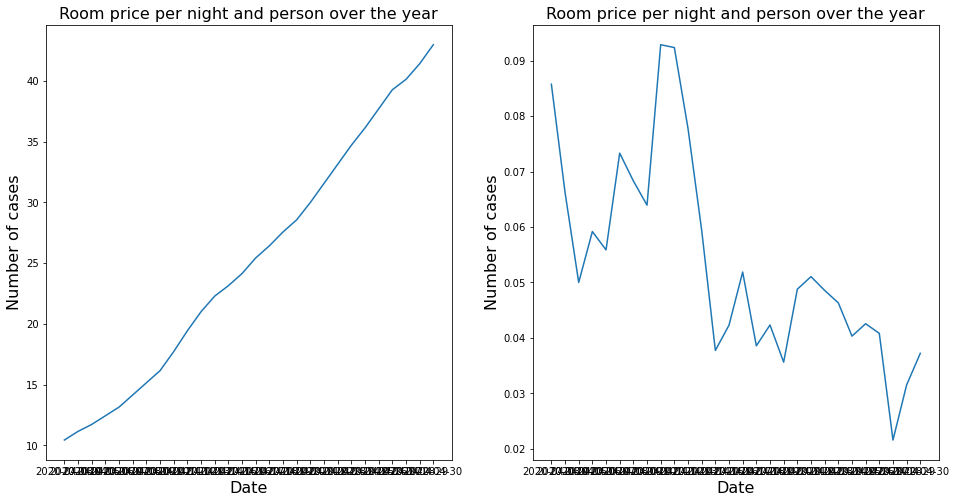

In [13]:
fip = 1001

plt.figure(figsize=(12,8))
plt.subplots(figsize=(16,8))
plt.subplot(1,2,1)
sns.lineplot(x="date",y="cases_7",data=df_case_delta[df_case_delta['fips']==fip])
plt.title("Room price per night and person over the year", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.xticks(rotation=0)
plt.ylabel("Number of cases", fontsize=16)

plt.subplot(1,2,2)
sns.lineplot(x="date",y="delta_case",data=df_case_delta[df_case_delta['fips']==fip])
plt.title("Room price per night and person over the year", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.xticks(rotation=0)
plt.ylabel("Number of cases", fontsize=16)
plt.show()

In [ ]:
fips = list(set(df_case_delta['fips']))
df_sir_av = []
for fip in tqdm(fips):
    temp = {
        "fips":fip,
        "delta_case":np.mean(df_case_delta[df_case_delta['fips']==fip]['delta_case'])
    }
    df_sir_av.append(temp)
    pass
df_sir_av = pd.DataFrame(df_sir_av)
    

In [15]:
# Putting all observations in regression
# df_case_demo = pd.merge(df_case_delta[['fips','delta_case','date','day_index','policy_home','policy_school','policy_business']],df_sd.drop(columns=["index","Race_White","WorkType_Office","Transp_Drive","Work_PrivateWork","IncomeErr","IncomePerCapErr","county","state","state_code","Crime_AG_ARRST"]+crime_columns),left_on="fips",right_on="fips")
df_case_demo = pd.merge(df_case_delta[['fips','delta_case','date','day_index']],df_sd.drop(columns=["index","Race_White","WorkType_Office","Transp_Drive","Work_PrivateWork","IncomeErr","IncomePerCapErr","county","state","state_code","Crime_AG_ARRST"]+crime_columns),left_on="fips",right_on="fips")


# Averaging the growth rate
# df_case_demo = pd.merge(df_sir_av[['fips','delta_case']],df_sd.drop(columns=["index","IncomeErr","IncomePerCapErr","county","state","state_code","Crime_AG_ARRST"]+crime_columns),left_on="fips",right_on="fips")

X = df_case_demo.drop(columns=["delta_case"])
y = df_case_demo['delta_case']

In [16]:
X['median_age_2017'] = X['median_age_2017']/100
X['l_population_2017'] = np.log(X['population_2017'])
X['female_percentage_2017'] = X['female_percentage_2017'] / 100
X['Race_Hispanic'] = X['Race_Hispanic'] / 100
# X['Race_White'] = X['Race_White'] / 100
X['Race_Black'] = X['Race_Black'] / 100
X['Race_Native'] = X['Race_Native'] / 100
X['Race_Asian'] = X['Race_Asian'] / 100
X['Race_Pacific'] = X['Race_Pacific'] / 100
X['l_income'] = np.log(X['Income'])
X['WorkType_Professional'] = X['WorkType_Professional'] / 100
X['WorkType_Construction'] = X['WorkType_Construction'] / 100
X['WorkType_Service'] = X['WorkType_Service'] / 100
# X['WorkType_Office'] = X['WorkType_Office'] / 100
X['WorkType_Production'] = X['WorkType_Production'] / 100
# X['Constant'] = 1

columns = list(X.columns)
del columns[columns.index('fips')]
del columns[columns.index('date')]
for index1,f1 in enumerate(columns):
    for index2, f2 in enumerate(columns[index1:]):
        X[f1 + "_" + f2] = X[f1] * X[f2]       
        pass
    pass
print(columns)
# X['Day_Day'] = X['day_index'] * X['day_index']
# X = X[['median_age_2017',"female_percentage_2017","Race_White","Race_Black","Race_Hispanic","l_income","l_population_2017","WorkType_Construction"]]

# poly = PolynomialFeatures(interaction_only=False, include_bias=True, degree=2)
# X = poly.fit_transform(X)

# X.drop(columns=["fips","population_2017"],inplace=True)

['day_index', 'median_age_2017', 'population_2017', 'female_percentage_2017', 'lat', 'long', 'Race_Hispanic', 'Race_Black', 'Race_Native', 'Race_Asian', 'Race_Pacific', 'VotingAgeCitizen', 'Income', 'IncomePerCap', 'Poverty', 'ChildPoverty', 'WorkType_Professional', 'WorkType_Service', 'WorkType_Construction', 'WorkType_Production', 'Transp_Carpool', 'Transp_Transit', 'Transp_Walk', 'Transp_OtherTransp', 'Transp_WorkAtHome', 'MeanCommute', 'Employed', 'Work_PublicWork', 'Work_SelfEmployed', 'Work_FamilyWork', 'Work_Unemployment', 'l_population_2017', 'l_income']


In [17]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=0.375,random_state = 10)

X_train_info = X_train[['fips','date']]
X_test_info = X_test[['fips','date']]
X_valid_info = X_valid[['fips','date']]
X_train = X_train.drop(columns=['fips','date'])
X_test = X_test.drop(columns=['fips','date'])
X_valid = X_valid.drop(columns=['fips','date'])

In [ ]:
print(y.head(5))
print(X.info())
# print(X.head(10))

In [ ]:
# print(X.info())

model_lr = LinearRegression()
model_lr.fit(X_train,y_train)

train_pred = model_lr.predict(X_train)
valid_pred = model_lr.predict(X_valid)

mse_score_lr_train = mean_squared_error(model_lr.predict(X_train), y_train)
mse_score_lr_valid = mean_squared_error(model_lr.predict(X_valid), y_valid)
r2_score_lr_train = r2_score(train_pred,y_train)
r2_score_lr_valid = r2_score(valid_pred,y_valid)


print(f"Linear Regression MSE on trainset is {mse_score_lr_train:.4f}")
print(f"Linear Regression MSE on validset is {mse_score_lr_valid:.4f}")
print(f"Linear Regression R2 on trainset is {r2_score_lr_train:.4f}")
print(f"Linear Regression R2 on validset is {r2_score_lr_valid:.4f}")
print(model_lr.coef_)
print(model_lr.intercept_)

In [ ]:
fip = 1013

Train_display = X_train.copy()
Train_display['y_true'] = y_train
Train_display['y_pred'] = train_pred
Train_display['fips'] = X_train_info['fips']
Train_display['date'] = X_train_info['date']
Train_display = Train_display[Train_display['fips']==fip]


plt.figure(figsize=(12,8))
sns.lineplot(x=Train_display['date'],y=Train_display['y_true'],data=Train_display)
sns.lineplot(x=Train_display['date'],y=Train_display['y_pred'],data=Train_display)
plt.title("", fontsize=16)
plt.xlabel("Date", fontsize=16)
plt.xticks(rotation=0)
plt.ylabel("log(growRate)", fontsize=16)


In [ ]:
model_lasso = Lasso(alpha=0.001)
model_lasso.fit(X_train,y_train)

train_pred = model_lasso.predict(X_train)
valid_pred = model_lasso.predict(X_valid)

mse_score_lr_train = mean_squared_error(train_pred, y_train)
mse_score_lr_valid = mean_squared_error(valid_pred, y_valid)
r2_score_lr_train = r2_score(train_pred,y_train)
r2_score_lr_valid = r2_score(valid_pred,y_valid)


print(f"Linear Regression MSE on trainset is {mse_score_lr_train:.4f}")
print(f"Linear Regression MSE on validset is {mse_score_lr_valid:.4f}")
print(f"Linear Regression R2 on trainset is {r2_score_lr_train:.4f}")
print(f"Linear Regression R2 on validset is {r2_score_lr_valid:.4f}")

In [ ]:
ols = sm.OLS(y_train,X_train).fit()
print(ols.summary())

### 3.2.2 Decision Tree

In [18]:
depth = [10,20,30,40,50]
train_mse_322 = []
valid_mse_322 = []
train_r2_322 = []
valid_r2_322 = []
for d in tqdm(depth):
    
    model_lr = DecisionTreeRegressor(max_depth=d)
    model_lr.fit(X_train,y_train)

    train_pred = model_lr.predict(X_train)
    valid_pred = model_lr.predict(X_valid)

    mse_score_lr_train = mean_squared_error(model_lr.predict(X_train), y_train)
    mse_score_lr_valid = mean_squared_error(model_lr.predict(X_valid), y_valid)
    r2_score_lr_train = r2_score(train_pred,y_train)
    r2_score_lr_valid = r2_score(valid_pred,y_valid)
    train_mse_322.append(mse_score_lr_train)
    valid_mse_322.append(mse_score_lr_valid)
    
    train_r2_322.append(r2_score_lr_train)
    valid_r2_322.append(r2_score_lr_valid)


# print(f"Linear Regression MSE on trainset is {mse_score_lr_train:.4f}")
# print(f"Linear Regression MSE on validset is {mse_score_lr_valid:.4f}")
# print(f"Linear Regression R2 on trainset is {r2_score_lr_train:.4f}")
# print(f"Linear Regression R2 on validset is {r2_score_lr_valid:.4f}")
# print(model_lr.coef_)
# print(model_lr.intercept_)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:53<00:00, 10.69s/it]


The best train score is 1.0
The best valid score is 0.6908281627676022


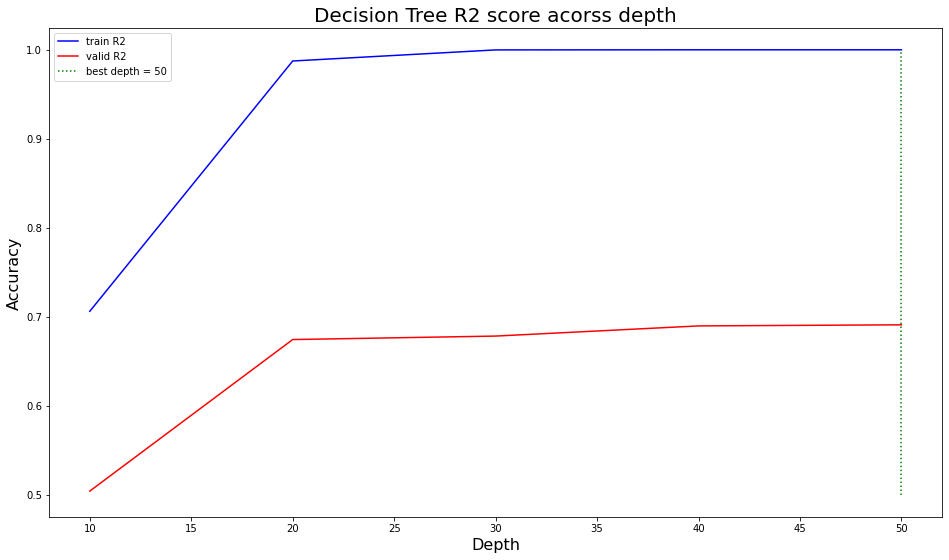

In [21]:
best_depth_index = np.argmax(valid_r2_322)
plt.figure(figsize=(16,9))
plt.plot(depth,train_r2_322,"b",label="train R2")
plt.plot(depth,valid_r2_322,"r",label="valid R2")
plt.vlines(depth[best_depth_index],0.5, 1, linestyles ="dotted", colors ="g",label=f"best depth = {depth[best_depth_index]}")
plt.xlabel("Depth", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.legend()
plt.title("Decision Tree R2 score acorss depth",fontsize=20)

print(f"The best train score is {train_r2_322[best_depth_index]}")
print(f"The best valid score is {valid_r2_322[best_depth_index]}")

###  3.2 Prediction on future

In [ ]:
# Prepare 5 days value
mData2 = []
for i in range(len(mData1)-5):
    temp = {
        "fips": mData1[i]['fips'],
        "day_5": mData1[i]['cases_7'],
        "day_4": mData1[i+1]['cases_7'],
        "day_3": mData1[i+2]['cases_7'],
        "day_2": mData1[i+3]['cases_7'],
        "day_1": mData1[i+4]['cases_7'],
        "day_0": mData1[i+5]['cases_7']
    }
    mData2.append(temp)
df_5_days = pd.DataFrame(mData2)

In [ ]:
df_5_days = df_5_days[df_5_days['day_5']>=10]
df_5_days.dropna(inplace=True)

In [ ]:
df_predict_demo = pd.merge(df_5_days,df_sd.drop(columns=["index","IncomeErr","IncomePerCapErr","county","state","state_code","Crime_AG_ARRST"]+crime_columns),left_on="fips",right_on="fips")

X = df_predict_demo.drop(columns=["day_0"])
y = df_predict_demo['day_0']

In [ ]:
X['median_age_2017'] = X['median_age_2017']/100
X['l_population_2017'] = np.log(X['population_2017'])
X['female_percentage_2017'] = X['female_percentage_2017'] / 100
X['Race_Hispanic'] = X['Race_Hispanic'] / 100
X['Race_White'] = X['Race_White'] / 100
X['Race_Black'] = X['Race_Black'] / 100
X['Race_Native'] = X['Race_Native'] / 100
X['Race_Asian'] = X['Race_Asian'] / 100
X['Race_Pacific'] = X['Race_Pacific'] / 100
X['l_income'] = np.log(X['Income'])
X['WorkType_Professional'] = X['WorkType_Professional'] / 100
X['WorkType_Construction'] = X['WorkType_Construction'] / 100
X['WorkType_Service'] = X['WorkType_Service'] / 100
X['WorkType_Office'] = X['WorkType_Office'] / 100
X['WorkType_Production'] = X['WorkType_Production'] / 100
X['day_5'] = np.log(X['day_5'])
X['day_4'] = np.log(X['day_4'])
X['day_3'] = np.log(X['day_3'])
X['day_2'] = np.log(X['day_2'])
baseLine = X['day_1']
# X['day_1'] = np.log(X['day_1'])
# y = np.log(y)
X = X[['median_age_2017',"female_percentage_2017","Race_White","Race_Black","Race_Hispanic","l_income","l_population_2017","WorkType_Construction"]]

# poly = PolynomialFeatures(interaction_only=False, include_bias=True, degree=2)
# X = poly.fit_transform(X)

# X.drop(columns=["fips","population_2017"],inplace=True)

In [ ]:
X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=5)
X_train,X_valid,y_train,y_valid = train_test_split(X_train,y_train,test_size=0.375,random_state = 10)

In [ ]:
print(X)
print(y)

In [ ]:
# print(X.info())

model_lr = LinearRegression()
model_lr.fit(X_train,y_train)

train_pred = model_lr.predict(X_train)
valid_pred = model_lr.predict(X_valid)

mse_score_lr_train = mean_squared_error(model_lr.predict(X), y)
mse_score_lr_valid = mean_squared_error(model_lr.predict(X), y)
mse_score_baseline = mean_squared_error(baseLine, y)
r2_score_lr_train = r2_score(train_pred,y_train)
r2_score_lr_valid = r2_score(valid_pred,y_valid)
r2_score_baseline = r2_score(baseLine,y)


print(f"Linear Regression MSE on trainset is {mse_score_lr_train:.4f}")
print(f"Linear Regression MSE on validset is {mse_score_lr_valid:.4f}")
print(f"Linear Regression MSE on baseline is {mse_score_baseline:.4f}")
print(f"Linear Regression R2 on trainset is {r2_score_lr_train:.4f}")
print(f"Linear Regression R2 on validset is {r2_score_lr_valid:.4f}")
print(f"Linear Regression R2 on baseline is {r2_score_baseline:.4f}")

In [ ]:
print(model_lr.coef_)